In [60]:
# Numpy for loading calculations into multidimensional arrays
import numpy as np 
import pandas as pd 

from time import time
import re
import string
import os
from pprint import pprint

# Provides different types of containers e.g 'Counter' that is used for processing word count
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

import gensim

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')











In [2]:
data0 = pd.read_csv(r'labeled.csv',encoding="ISO-8859-1")
data0

,content,sentiment
0,joe biden say get place putin decid invad russia peopl vote guy,neutral
1,like countri sovereign proven valid concern would invad talk legitim secur concern legitim secur concern equat ukrain russia neighbor,positive
2,nato aggressor mayb russia declar war nato would hoot instead decid invad weaker neighbor unprovok find much fun thought,negative
3,zelenski put power coup ukrain want russia ukrain one forc russia invad russia made decis pay,negative
4,point ukrain ask nato eu help russia would happen anyway mean like russia go invad ukrain right,positive
...,...,...
165242,approach putin domest pressur think invad ukrain pull june nd hitler invad russia hope buy time may ww happi new year putin may go biolog also use fog war covid potenc,negative
165243,predict year russia invad ukrain januari china invad twain late spring summer covid still time next year,neutral
165244,ye sure stand america would never left anyon afghanistan russia invad well anyon one would mess isreal would afraid firestorm would rain,positive
165245,russia own cuba venezuela putin want ukrain kgb alway kgb putin dictat dictat invad nobodi question mysteri accid,positive


In [3]:
data0.drop(data0.index[1999:170834], inplace=True)

In [4]:
# Creating a class TextCounts for text analysis

from sklearn.base import BaseEstimator, TransformerMixin

class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        
        data0 = pd.DataFrame({'count_words': count_words })
        
        return data0
    


In [5]:
tc = TextCounts()
data0_eda = tc.fit_transform(data0.content)
data0_eda['sentiment'] = data0.sentiment
data0_eda

,count_words,sentiment
0,12,neutral
1,19,positive
2,19,negative
3,16,negative
4,17,positive
...,...,...
1994,28,negative
1995,25,negative
1996,24,negative
1997,26,negative


In [6]:
# Descriptive text stats per target class

sns.set(style="darkgrid")
sns.set(font_scale=1.3)

def show_dist(data0, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(data0.groupby('sentiment')[col].describe())
    bins = np.arange(data0[col].min(), data0[col].max() + 1)
    g = sns.FacetGrid(data0, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for count_words
---------------------------------
           count       mean       std  min   25%   50%   75%   max
sentiment                                                         
negative   914.0  20.669584  6.385242  4.0  16.0  22.0  25.0  38.0
neutral    388.0  11.206186  6.317505  2.0  6.0   10.0  15.0  29.0
positive   697.0  18.747489  6.852883  3.0  13.0  19.0  25.0  34.0


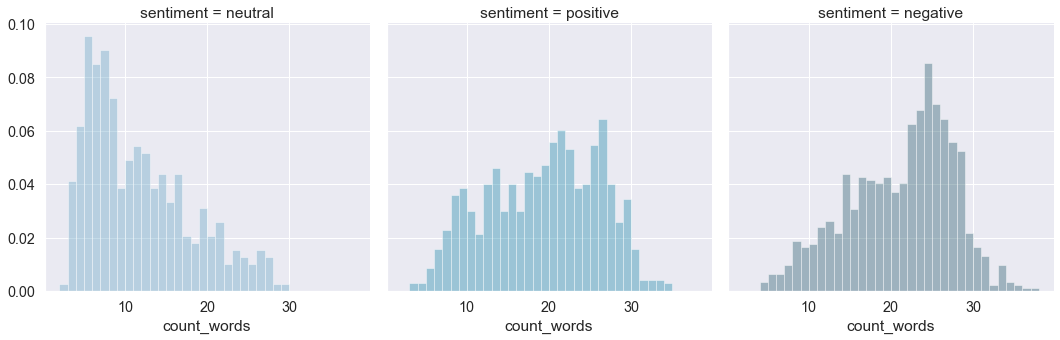

In [7]:
show_dist(data0_eda, 'count_words')

In [8]:
data_clean = data0['content']

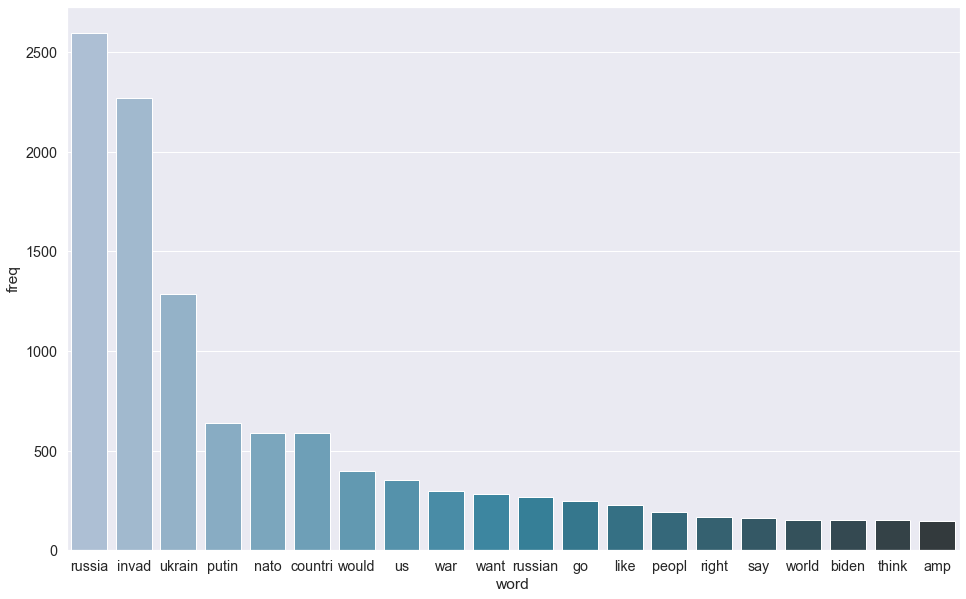

In [9]:
# Freq plot for 20 most used words
cv = CountVectorizer()
bow = cv.fit_transform(data_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])

fig, ax = plt.subplots(figsize=(16, 10))
bar_freq_word = sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.show();

In [10]:
# Combining the TextCounts variables with the CleanText variable

data0_model = data0_eda
data0_model['clean_text'] = data_clean
data0_model.columns.tolist()


['count_words', 'sentiment', 'clean_text']

In [11]:
data_clean.sample(5)

3        zelenski put power coup ukrain want russia ukrain one forc russia invad russia made decis pay 
1219     joe biden made russia invad ukrain stop american freedom convoy                               
1535     help ukrain win send russia pack invad anoth countri becom third rate countri                 
102      happen republ ireland decid join militari allianc russia jave doubt uk would invad            
1363     russia invad usf accident invad miami aim south florida                                       
Name: content, dtype: object

In [12]:
# To specifically select columns that is used for vectorization
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self

In [13]:
# splitting data frame for model

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data0_model.drop('sentiment', axis=1), data0_model.sentiment, test_size=0.2, random_state=37)

In [56]:

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None):
    
    textcountscols = ['count_words']
    

    features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols)), ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
    
    
        
    return grid_search

In [43]:
# Parameter grid settings for the vectorizers (Count and TFIDF)

parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}

# Count Vectorizer

In [57]:
# Naive Bayes using count vectorizer
mnb = MultinomialNB()
best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=cv)


Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'features__pipe__vect__max_df': (0.25, 0.5, 0.75), 'features__pipe__vect__ngram_range': ((1, 1), (1, 2)), 'features__pipe__vect__min_df': (1, 2), 'clf__alpha': (0.25, 0.5, 0.75)}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
done in 4.544s

Best CV score: 0.652
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.593


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.61      0.72      0.66       179
     neutral       0.68      0.32      0.43        78
    positive       0.55      0.58      0.57       143

    accuracy                           0.59       400
   macro avg       0.61      0.54      0.55       400
weighted avg       0.60      0.59      0.58       400



In [30]:
# LogisticRegression using count vectorizer

logreg = LogisticRegression()
best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=cv)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'features__pipe__vect__max_df': (0.25, 0.5, 0.75), 'features__pipe__vect__ngram_range': ((1, 1), (1, 2)), 'features__pipe__vect__min_df': (1, 2), 'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 72 candidates, totalling 360 fits
done in 43.414s

Best CV score: 0.735
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.723


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.76      0.75      0.75       179
     neutral       0.68      0.69      0.68        78
    positive       0.70      0.71      0.70       143

    accuracy                           0.72       400
   macro avg       0.71      0.72      0.71       400
weighted avg       0.72      0.72      0.72       400



# TF-IDF

In [19]:
tfidfvect = TfidfVectorizer()

In [58]:
# Naive Bayes using TF-IDf
best_mnb_tfidf = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'features__pipe__vect__max_df': (0.25, 0.5, 0.75), 'features__pipe__vect__ngram_range': ((1, 1), (1, 2)), 'features__pipe__vect__min_df': (1, 2), 'clf__alpha': (0.25, 0.5, 0.75)}
Fitting 5 folds for each of 36 candidates, totalling 180 fits
done in 4.686s

Best CV score: 0.621
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.590


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.56      0.87      0.68       179
     neutral       1.00      0.12      0.21        78
    positive       0.63      0.50      0.55       143

    accuracy                           0.59       400
   macro avg       0.73      0.49      0.48       400
weighted avg       0.67      0.59      0.54       400



In [31]:
# LogisticRegression using TF-IDF
best_logreg_tfidf = grid_vect(logreg, parameters_logreg, X_train, X_test, parameters_text=parameters_vect, vect=tfidfvect)

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'features__pipe__vect__max_df': (0.25, 0.5, 0.75), 'features__pipe__vect__ngram_range': ((1, 1), (1, 2)), 'features__pipe__vect__min_df': (1, 2), 'clf__C': (0.25, 0.5, 1.0), 'clf__penalty': ('l1', 'l2')}
Fitting 5 folds for each of 72 candidates, totalling 360 fits
done in 41.398s

Best CV score: 0.715
Best parameters set:
	clf__C: 1.0
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Test score with best_estimator_: 0.705


Classification Report Test Data
              precision    recall  f1-score   support

    negative       0.72      0.83      0.77       179
     neutral       0.66      0.64      0.65        78
    positive       0.71      0.58      0.64       143

    accuracy                           0.70       400
   macro avg       0.70      0.68      0.69       400
weighted avg       0.70      0.70      0.70       400

